# Explore the landcover mapping for a small test file that has been classified and for the full landcover for 2018


Test files can be found https://universityofcambridgecloud.sharepoint.com/:f:/r/sites/ESC_FireProject-AI4ER/Shared%20Documents/General/Data/Landcover%20mapping/Test_area/Classified_files?csf=1&web=1&e=Uvvxt9

Full Landcover mapping data can be cloned from  https://github.com/graceebc9/Fire_data/Classified 

Key for landcover is in technical report, found here https://universityofcambridgecloud.sharepoint.com/:b:/r/sites/ESC_FireProject-AI4ER/Shared%20Documents/General/Polesia_classification_tool_technical_report%20v1.pdf?csf=1&web=1&e=zhOnV3
Next step is to combine this with the mapping, although I believe that for the model we do not need to provide the classification 

The Polesia map split into tiles:

In [ ]:
from IPython.display import Image
Image("/Users/gracecolverd/Documents/Fire_Proj/polesia_mapping.jpeg")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import rasterio
from rasterio.plot import show 
import os, glob

import rioxarray
from rioxarray import merge

In [ ]:
#define some functions 

def combine_tif_small(file_list, title = ''):
    """Plot the combined image of a set of tif files - limits to ~125 files before datasets close
    file_list = list of files to be merged
    title = title for plot 
    """
    import rioxarray
    from rioxarray import merge
    from rasterio.plot import show 
    
    fig, ax = plt.subplots( figsize=(10,10))

    elements = []

    for val in file_list:
        elements.append(rioxarray.open_rasterio(val))

    merged = merge.merge_arrays(elements, nodata=0.0)

    image = merged.values
    show(image, ax=ax, title = title)

def plot_two_tif(files_1, files_2, title1 ='' , title2 = ''):
    """Plot two combined images side by side, for small lists of files < 125 each   
    files_1 : list of first files 
    files2: list of second files 
    """
    import rioxarray
    from rioxarray import merge
    from rasterio.plot import show 
    
    files = (files_1, files_2)
    titles = (title1, title2)
    image_s = []
    fig, ax = plt.subplots(1,2, figsize=(20,40))
    
    t = 0
    for f in files:
        elements = []
        for val in f:
            elements.append(rioxarray.open_rasterio(val))

        merged = merge.merge_arrays(elements, nodata=0.0)

        image = merged.values
        show(image, ax=ax[t], title = titles[t])
        t=t+1
    

In [ ]:
def combine_tif_large(file_list, title=''):
    import rioxarray
    from rioxarray import merge
    from rasterio.plot import show 
    
    """Plot the combined image of a set of tif files - chunks long file list into groups of 100 (n) to prevent datasets closing
    file_list = list of files to be merged
    title = title for plot 
    """
    n= 100 
    fig, ax = plt.subplots( figsize=(20,20))
    chunked_files = [file_list[i:i + n] for i in range(0, len(file_list), n)]
    test = chunked_files[:2]

    final = [] 
    for chunk in chunked_files:
        elements = []
        for val in chunk:
            elements.append(rioxarray.open_rasterio(val))

        merged = merge.merge_arrays(elements, nodata=0.0)
        final.append(merged)

    merge_final = merge.merge_arrays(final, nodata=0.0)
    image = merge_final.values
    show(image, ax = ax, title= title)  
    

In [ ]:
#list all files in simple and complex mapping for later combination 
simpel = glob.glob('/Users/gracecolverd/Documents/Fire_Proj/Test/Classified/*Simple.tif')
comple = glob.glob('/Users/gracecolverd/Documents/Fire_Proj/Test/Classified/*Complex.tif')

simple_polesia = glob.glob('/Users/gracecolverd/Documents/Fire_Proj/JASMIN/Fire_data/Classified/*Simple.tif')
complex_polesia = glob.glob('/Users/gracecolverd/Documents/Fire_Proj/JASMIN/Fire_data/Classified/*Complex.tif')

In [ ]:
#plot a simple and complex tile
simple = '/Users/gracecolverd/Documents/Fire_Proj/Test/Classified/PArea1_tile9_RF_2018_Simple.tif'
compl = '/Users/gracecolverd/Documents/Fire_Proj/Test/Classified/PArea1_tile9_RF_2018_Complex.tif' 

img = rasterio.open(simple)
img2 = rasterio.open(compl)

show(img)
show(img2)

In [ ]:
plot_two_tif(simpel, comple, 'Simple Landcover'  ,'Complex Landcover')

# Plotting the simple and complex land cover for all Polesia
There is one central tile missing from the simple verison - parea23_33- likely due to lack of band of satellite data 


In [ ]:
combine_tif_large(complex_polesia, title= 'Complex')
combine_tif_large(simple_polesia, title = 'Simple')

# Looking at the Complex landcover map in QGIS
I compare the landcover TIFs (black and white) to the SHP processing areas generated (colourful squares). The RHS where landcover is missing is likley due to a missing band from the Satellite data, e.g. no vegetation. This only overlaps with the 'whole_map' shapefile by a small amount as seen in the bottom image below with the yellow shapefile superimposed 

In [ ]:
Image('/Users/gracecolverd/Documents/Fire_Proj/Image 10-01-2022 at 17.59.jpeg')

In [ ]:

Image('/Users/gracecolverd/Documents/Fire_Proj/Polesia-mapping-landcover.png')

# Marginally More Concise Method of Mosaic'ing the TIF Files
Having messed about with rasterio for a couple of hours, it became apparent that any chunking was in fact unecessary. Below is the slightly more concise code that resulted.

### Prerequisites
Before being able to run the below code, a suitable conda environment must be set up.
This environment must be set up to handle the rioxarray module, and associated useful modules.
If you already have miniconda set up on your local PC all you need to do is set up the environment from the terminal.
The following code will be of use:
- $ conda config --prepend channels conda-forge
- $ conda config --set channel-priority strict
- $ conda create -n rioxarray_env rioxarray
- $ conda activate rioxarray_env
- $ conda install ipykernel
- $ conda install matplotlib
- $ conda install -c conda-forge earthpy

In [1]:
# Required modules are imported.
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from affine import Affine
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
import earthpy.plot as ep

In [2]:
# First of all the list of simple-landcover 2018 tif files are imported from local repository.
geotif_list = glob.glob('/Users/thomasdodd/OneDrive - Millfield Enterprises Limited/Cambridge/AI4ER/Lent/GTC/practice_classified_files/Fire_data/Classified/*Simple.tif')

In [3]:
# An array is defined, into which all the opened tifs can be placed.
src_files_to_mosaic = []

# A for loop is used to iterate through the geotif_list,
# opening them and placing them in the src_files_to_mosaic
for geotif in geotif_list:
    src = rasterio.open(geotif)
    src_files_to_mosaic.append(src)

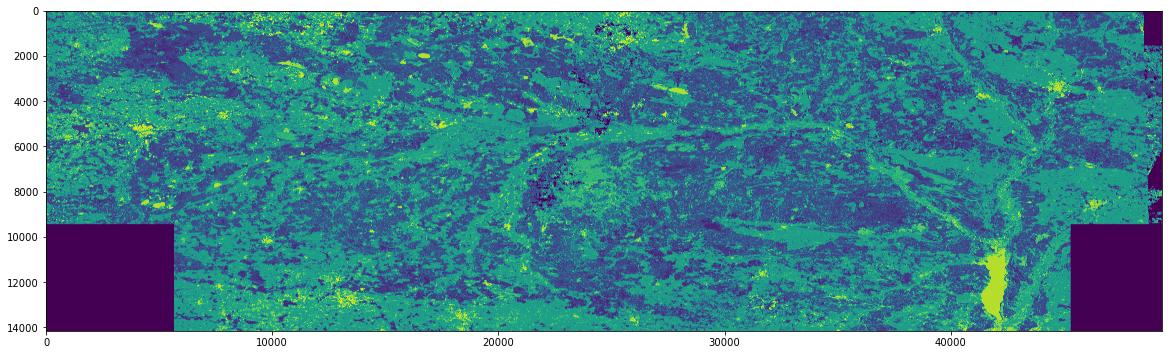

<AxesSubplot:>

In [4]:
plt.close("all")
# The soon to be plotted figure has its size set.
fig, ax = plt.subplots(figsize=(20,20))
# The mosaic of merged tif files is generated.
mosaic, out_trans = rasterio.merge.merge(src_files_to_mosaic)
# The mosaic is plotted.
show(mosaic)

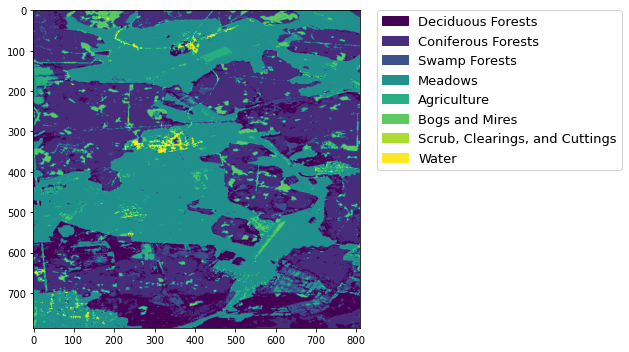

In [5]:
# Test snippet of code, showing how to get a discrete legend instead of a continuous colourbar.
tile = rasterio.open(geotif_list[0])

plt.close("all")
f, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(tile.read(1))
ep.draw_legend(im, titles=["Deciduous Forests", "Coniferous Forests", "Swamp Forests", "Meadows", "Agriculture", "Bogs and Mires", "Scrub, Clearings, and Cuttings", "Water"]) #, "Urban"
plt.tight_layout()

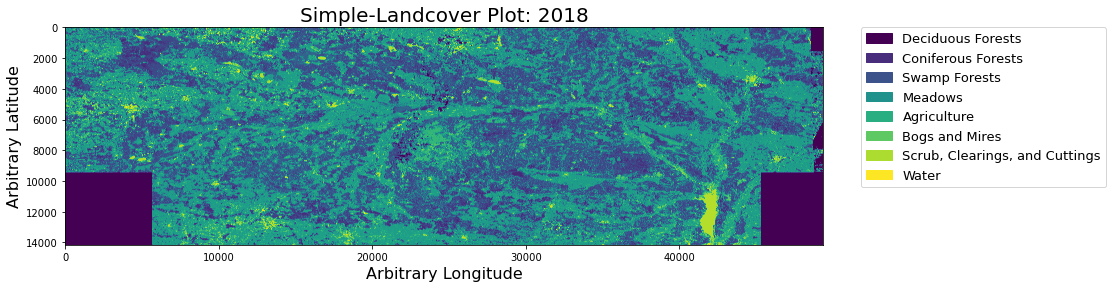

<AxesSubplot:title={'center':'Simple-Landcover Plot: 2018'}, xlabel='Arbitrary Longitude', ylabel='Arbitrary Latitude'>

In [7]:
# A full mosaic of the simple-landcover 2018 tif files is generated with a discrete colour bar.

plt.close("all")
# The soon to be plotted figure has its size set.
fig, ax = plt.subplots(figsize=(20,4))
# The mosaic of merged tif files is generated.
mosaic, out_trans = rasterio.merge.merge(src_files_to_mosaic)

# A single tile is opened, this provides the 'hidden' image for matplotlib, 
# which we will use to overlay plot the discrete key onto the mosaic.
tile = rasterio.open(geotif_list[0])
im = ax.imshow(tile.read(1))
ep.draw_legend(im, titles=["Deciduous Forests", "Coniferous Forests", "Swamp Forests", "Meadows", "Agriculture", "Bogs and Mires", "Scrub, Clearings, and Cuttings", "Water"]) #, "Urban"

ax.set_title(label="Simple-Landcover Plot: 2018",fontsize=20)
ax.set_xlabel('Arbitrary Longitude',fontsize=16);
ax.set_ylabel('Arbitrary Latitude',fontsize=16);
# The mosaic is plotted.
show(mosaic)